In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 

In [7]:
df = pd.read_csv('p1.csv').set_index('Date')
df.columns 

Index(['IXIC', 'GSPC', 'GDAXI'], dtype='object')

In [8]:
df = df.rename({'IXIC': 'CCMP', 'GSPC': 'SPX', 'GDAXI': 'Dax'}, axis=1) # change to bloomberg name...

In [39]:
df_return = df.pct_change(1)
df_return.tail()

,CCMP,SPX,Dax
Date,,,
2020-12-23,-0.002874,0.000746,0.003904
2020-12-24,0.002633,0.003537,-0.000783
2020-12-28,0.007395,0.008723,0.012605
2020-12-29,-0.003814,-0.002227,-0.000199
2020-12-30,0.001539,0.001342,-0.000243


### Assumption, we assume the returns are normally distributed (actually a bit skewed and with some fat left tail, but ignore this)

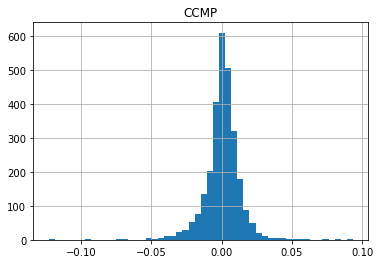

In [37]:
## Check distribution of return 
plt.hist(df_return['CCMP'], bins=50)
plt.title('CCMP')
plt.grid()

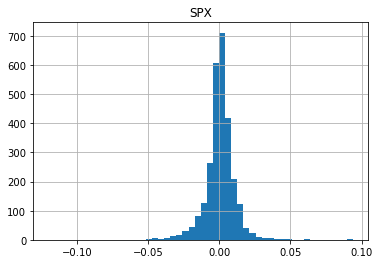

In [27]:
plt.hist(df_return['SPX'], bins=50)
plt.title('SPX')
plt.grid()

Histogram shows the returns roughtly follows Gaussian, slightly left skewed (as expected with a 10year bull run in the US market plus some significant daily corrections)

Text(0.5, 1.0, 'Scatter plot of CCMP SPX returns')

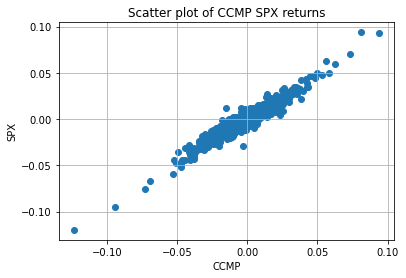

In [26]:
plt.scatter(df_return['CCMP'], df_return['SPX'])
plt.xlabel('CCMP')
plt.ylabel('SPX')
plt.grid()
plt.title('Scatter plot of CCMP SPX returns')

Scatter plot shows the return correlation is very high, as expected from S&P and Nasdaq 

For correlation, we use pearson correlation of returns rather than price levels. 
###
#### Reason for return: 
###
We want to measure the deviation from the mean return rather than the mean price. 
###
Deviation from mean price over a time period actually do not carry much useful information. 
#
A positive (or as we can see below 0.95) shows the upward deviations from the mean of S&P returns 
        are simultaneous to upward deviations from the mean of Nasdaq returns 

##
##
 #### Reason for Pearson correlation:
 # 
 Linear relationship 
 # 
 Returns normally distributed (close to normal)
 # 
 Homoscedasticity (close to equally distributed around the mean)
 # 
 Other methods are mostly non-parametric, not suitable here
 

In [52]:
df_return[['CCMP', 'SPX']].corr()['SPX'].loc['CCMP']

0.9541129317834571

Pearson correlation is 0.954 over the whole preiod from 2010 to 2020


Also worth to plot how Pearson correlation change through time. Rolling 1 year (252 working days)

In [66]:
df_rolling_corr = df_return[['CCMP', 'SPX']].rolling(252).corr()['SPX'].loc[:,'CCMP'].dropna()
df_rolling_corr.index = pd.to_datetime(df_rolling_corr.index)

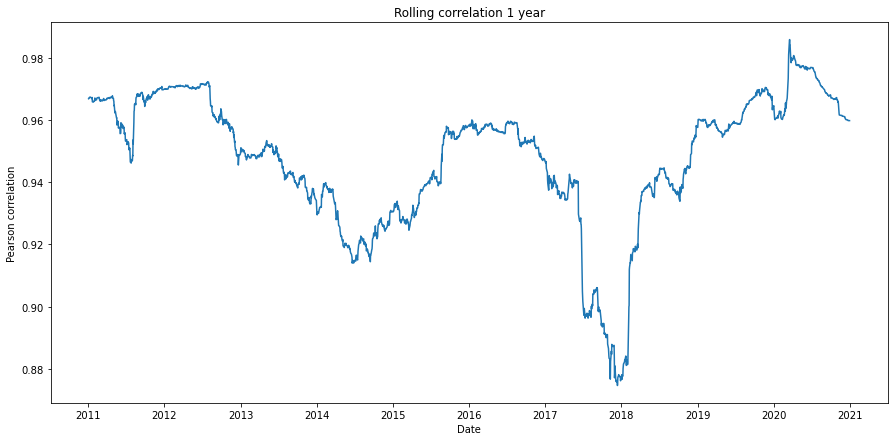

In [71]:
import matplotlib.dates as mdates 
fig, ax = plt.subplots(figsize=(15,7))
ax.plot(df_rolling_corr)
plt.xlabel('Date')
plt.ylabel('Pearson correlation')
plt.title('Rolling correlation 1 year')
dfFmt = mdates.DateFormatter('%Y')
ax.xaxis.set_major_formatter(dfFmt)


Rolling 1 year pearson correlation fluctuate a bit between 0.88 and 0.98, there was a big drawdown between 2017 and 2018 (dropped from 0.96 to 0.88)

## Question 2:

# 

There are many different ways to run portfolio optimisation, here we use: 
#
1. Using 3 year look back window for optimisation, start the first rebalance / optimisation on 2013-01-31 
# 
2. Rebalance monthly 
# 
3. We set optimisation target to sharpe ratio
# 
4. We use scipy optimise engine "SLSQP" method ('https://en.wikipedia.org/wiki/Sequential_quadratic_programming')
# 
5. We assume the only bound is: the weights of all three assets add up to 1 


In [101]:
# utiles functions 
from scipy.optimize import minimize

def max_drawdown(arr):

    i = np.argmax(np.maximum.accumulate(arr) - arr)
    j = np.argmax(arr[:i])

    max_dd = (arr[j] - arr[i]) / arr[i]
    return max_dd

def get_stats(weights, 
              df_return):
    """
    Given portfolio and weights, calculate:
        a. annualised return
        b. annualised volatility
        c. annualised sharpe ratio
        d. max drawdown

    :param weights: np.array. weights for each strategy
    :param df_return: percentage return for each strategy 
    :return: dict containing return, volatility, sharpe_ratio and max_drawdown 
    """
    multiplier = 252  # daily data 
    
    weights = np.array(weights)
    ret = np.sum(df_return.mean() * weights) * multiplier
    portfolio_cov_ann = df_return.cov() * multiplier
    portfolio_var_ann = np.dot(weights.T, 
                               np.dot(portfolio_cov_ann, weights)) 
    portfolio_std_ann = np.sqrt(portfolio_var_ann)

    sharpe_ratio = ret / portfolio_std_ann 
    vol = np.std(df_return) * np.sqrt(multiplier)
    div = np.sum(vol * weights) / portfolio_std_ann

    df_portfolio = (1+df_return).cumprod()
    component_total_return_contribution = (df_portfolio.iloc[-1] - df_portfolio.iloc[0]) / (df_portfolio.iloc[0])

    start_date, end_date = df_return.index[0], df_return.index[-1]
    rebalance_dates_index = pd.bdate_range(start=start_date, end=end_date, freq='BM')
    df_component_weights = pd.DataFrame(index=rebalance_dates_index, 
                                        data=[weights,]* len(rebalance_dates_index),
                                        columns=df_return.columns)\
                                        .rename_axis('Date')

    return {'return': ret,
            'volatility': portfolio_std_ann,
            'sharpe_ratio': sharpe_ratio,
            'return_contribution': component_total_return_contribution}


def negative_target(weights, df_return, target):
    """
    Get negative objective function for scipy minimize
    :param weights: (np array) weights of strategies
    :param df_return:
    :param target: (str): optimisation target, can be 'return',
                                                      'sharpe_ratio'
    """
    return get_stats(weights, df_return)[target] * (-1)


def portfolio_optimisation(df_return,
                           target='sharpe_ratio',
                           optimisation_method='SLSQP'):

    num_strategies = len(df_return.columns) # 3 in this case 
 
    # initialise weights
    init_weights = np.array(np.random.rand(num_strategies))
    init_weights /= np.sum(init_weights)

    
    cons = ({'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1})

    bounds = [[0, 1] for i in range(num_strategies)]

    opt_results = minimize(fun=negative_target,
                           x0=init_weights, 
                           args=(df_return, target),
                           method=optimisation_method,
                           bounds=bounds, 
                           constraints=cons)

    stats_results = get_stats(opt_results.x, df_return)

    ret = stats_results['return']
    volatility = stats_results['volatility']
    sharpe_ratio = stats_results['sharpe_ratio']
    weights_dict = {strategy: weight for strategy, weight in 
                    zip(df_return.columns, opt_results.x)}

    return {'objective': -opt_results.fun,
            'weights': weights_dict,
            'return': ret, # annualised return
            'volatility': volatility, # annualised vol
            'sharpe_ratio': sharpe_ratio # annualised sharpe ratio
            } 


In [139]:
# Run rolling optimisation 
start_date, end_date = df_return.index[0], df_return.index[-1]
optimisation_dates_list = list(pd.bdate_range(start=start_date, end=end_date, freq='BM'))

slicing_list = [[str(st_date)[:10], 
                str(pd.bdate_range(start=st_date, 
                                    periods=36+1, 
                                    freq='BM')[-1])[:10]] 
                for st_date in optimisation_dates_list][:-36]
                
rolling_optimisation_result = {} 

for dt_range in slicing_list:
    print(f'{dt_range[0]} ---- {dt_range[1]}')

    df_opt = df_return[(df_return.index >= dt_range[0]) &
                        (df_return.index <= dt_range[1])]

    rolling_optimisation_result[dt_range[1]] = portfolio_optimisation(df_opt,
                                                                      target='sharpe_ratio',
                                                                      optimisation_method='SLSQP')
                                                                      

2010-01-29 ---- 2013-01-31
2010-02-26 ---- 2013-02-28
2010-03-31 ---- 2013-03-29
2010-04-30 ---- 2013-04-30
2010-05-31 ---- 2013-05-31
2010-06-30 ---- 2013-06-28
2010-07-30 ---- 2013-07-31
2010-08-31 ---- 2013-08-30
2010-09-30 ---- 2013-09-30
2010-10-29 ---- 2013-10-31
2010-11-30 ---- 2013-11-29
2010-12-31 ---- 2013-12-31
2011-01-31 ---- 2014-01-31
2011-02-28 ---- 2014-02-28
2011-03-31 ---- 2014-03-31
2011-04-29 ---- 2014-04-30
2011-05-31 ---- 2014-05-30
2011-06-30 ---- 2014-06-30
2011-07-29 ---- 2014-07-31
2011-08-31 ---- 2014-08-29
2011-09-30 ---- 2014-09-30
2011-10-31 ---- 2014-10-31
2011-11-30 ---- 2014-11-28
2011-12-30 ---- 2014-12-31
2012-01-31 ---- 2015-01-30
2012-02-29 ---- 2015-02-27
2012-03-30 ---- 2015-03-31
2012-04-30 ---- 2015-04-30
2012-05-31 ---- 2015-05-29
2012-06-29 ---- 2015-06-30
2012-07-31 ---- 2015-07-31
2012-08-31 ---- 2015-08-31
2012-09-28 ---- 2015-09-30
2012-10-31 ---- 2015-10-30
2012-11-30 ---- 2015-11-30
2012-12-31 ---- 2015-12-31
2013-01-31 ---- 2016-01-29
2

In [207]:
df_rebalance_weights = pd.DataFrame(index=rolling_optimisation_result.keys(), data=[rolling_optimisation_result[date]['weights'] for date in rolling_optimisation_result.keys()])
df_return.index = pd.to_datetime(df_return.index)
df_rebalance_weights.index = pd.to_datetime(df_rebalance_weights.index)
df_monthly_return = df_return.resample('M').apply(lambda x: (1+x).prod()-1)
df_rebalance_weights = df_rebalance_weights.resample('M').mean()

#### Look at the weights through time, the optimiser assign a relatively large weights to Nasdaq, while S&P have very small weights. This is due to they have very high correlation, and Nasdaq outperformed S&P over the periods, hence the optmiser surpresses S&P weights.

In [208]:
max_sharpe_return = (1+((df_rebalance_weights.shift(1).fillna(0) * df_monthly_return).dropna()).sum(axis=1)).cumprod()

In [209]:
df_equal_weights =  df_rebalance_weights.copy()
df_equal_weights['CCMP'] = 1/3
df_equal_weights['SPX'] = 1/3
df_equal_weights['Dax'] = 1/3
equal_weight_return = (1+((df_equal_weights.shift().fillna(0) * df_monthly_return).dropna()).sum(axis=1)).cumprod()

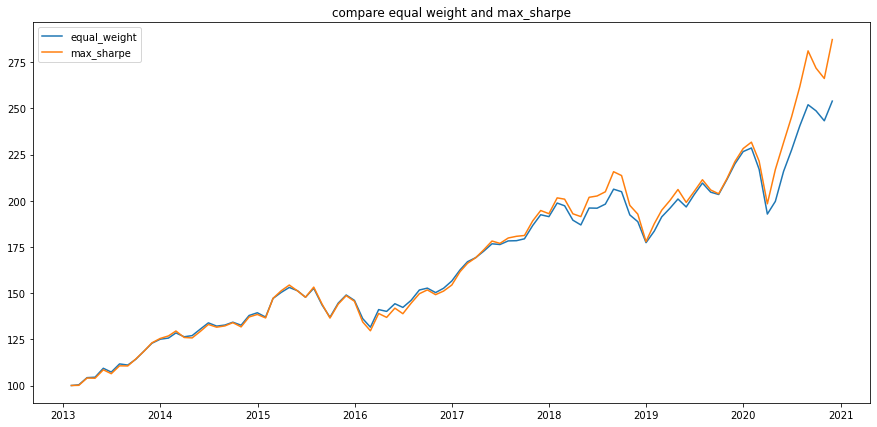

In [213]:
plt.figure(figsize=(15,7))
plt.plot(equal_weight_return*100, label='equal_weight')
plt.plot(max_sharpe_return*100, label='max_sharpe')
plt.title('compare equal weight and max_sharpe')
plt.legend()

### Overall The max sharpe portfolio outperformed equal weighted portfolio
### equal weighted portfolio had 18.55% max drawdown while max sharpe portfolio had 21.27% max drawdown

In [222]:
print('max_sharpe dd', round(max_drawdown(max_sharpe_return),4)*100, 'equal_weight dd', round(max_drawdown(equal_weight_return),4)*100)

max_sharpe dd 21.27 equal_weight dd 18.55
